### Comparison of `MLP`, `Random-Search Tuned MLP`, `RandOver MLP`, `SPE MLP`

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [10]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import ML libraries
import keras
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imbens.ensemble import SelfPacedEnsembleClassifier
from scikeras.wrappers import KerasClassifier

from pprint import pprint
from time import time
import joblib

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'CC_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

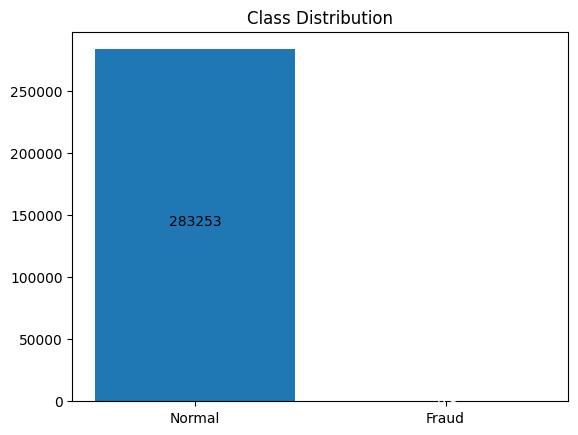

In [11]:
# Importing the dataset
path_to_data = '../data/creditcard/creditcard.csv'

# col names data set
col_names = [
    "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","label"
] # V1-V28 are PCA transformed features, but are anonymized due to confidentiality reasons and are not interpretable
# Label is 1 if fraud, 0 otherwise

# read full data set
data = pd.read_csv(path_to_data, names=col_names, index_col=0, header=0)

# drop duplicates  & time column
data.drop_duplicates(inplace=True)
data.drop("Time", axis=1, inplace=True)

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Stratified 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# To numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Reshape
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Set Weight
res_value_counts = df(y_train).value_counts()
weight_for_0 = 1.0 / res_value_counts[0]
weight_for_1 = 1.0 / res_value_counts[1]

# Visualize class imbalance
plt.bar(["Normal", "Fraud"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1])
normal_percentage = (data["label"].value_counts()[0])

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage}', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage}', ha='center', color='white')
plt.title("Class Distribution")
plt.show()

### 2. Define models and parameters

In [12]:
## Credits for model architecture: https://keras.io/examples/structured_data/imbalanced_classification/

def _mlp(name="mlp"):
    # Hyperparameters
    data_dim = np.shape(X_train)[1]
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    Adam = keras.optimizers.Adam(learning_rate)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    # Define model
    model = keras.Sequential(
        [
            keras.Input(shape=(data_dim,)),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    # Define metrics
    metrics = [
        keras.metrics.F1Score(name="f1"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
    ]

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            f"./ckp/{CKP_PREFIX}{name}/epoch_" + "{epoch}" + ".keras"
        )
    ]

    return KerasClassifier(
        model,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        loss="binary_crossentropy",
        callbacks=callbacks,
        metrics=metrics,
        optimizer=Adam,
        class_weight=class_weight,
        random_state=RANDOM_STATE,
    )


# MLP Normal
mlp_pipeline = Pipeline([("scale", StandardScaler()), ("mlp", _mlp('mlp'))])

# MLP SPE
mlp_spe_pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        (
            "spe_mlp",
            SelfPacedEnsembleClassifier(
                estimator=_mlp('spe_mlp'),
                n_estimators=50, # number of base estimators (default 50)
                n_jobs=-1, # Use all available cores
                verbose=1,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
) 

# MLP Random Oversampling
mlp_ros_pipeline = imblearn_pipeline(
    [
        ("scale", StandardScaler()),
        ("ros", RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy=1)), # 1:1 ratio
        ("mlp", _mlp('ros_mlp')),
    ]
)


# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

### 3. Perform Cross-Validation on the training data

In [9]:
# 5-fold cross-validation for MLP Normal
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for MLP Normal:")

mlp_scores = cross_validate(
    mlp_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
mlp_scores_df = pd.DataFrame(mlp_scores)

# Print mean ± standard deviation of scores
print("\nMLP Normal:")
for metric in scoring.keys():
    mean_score = mlp_scores_df[f'test_{metric}'].mean()
    std_score = mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


# 5-fold cross-validation for Self-paced ensemble classifier
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP SPE:")

spe_boosted_mlp_scores = cross_validate(
    mlp_spe_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_boosted_mlp_scores_df = pd.DataFrame(spe_boosted_mlp_scores)

print("\nSelf-paced ensemble classifier:")
for metric in scoring.keys():
    mean_score = spe_boosted_mlp_scores[f'test_{metric}'].mean()
    std_score = spe_boosted_mlp_scores[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

# 5-fold cross-validation for Random Oversampling
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Random Oversampling:")
ros_mlp_scores = cross_validate(
    mlp_ros_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
ros_mlp_scores_df = pd.DataFrame(ros_mlp_scores)

print("\nRandom Oversampling:")
for metric in scoring.keys():
    mean_score = ros_mlp_scores_df[f'test_{metric}'].mean()
    std_score = ros_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for MLP Normal:

MLP Normal:
f1: 0.3029 ± 0.1485
precision: 0.1923 ± 0.1057
recall: 0.8860 ± 0.0509

5-fold cross-validation for MLP SPE:


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    3.7s remaining:   14.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    3.9s remaining:   15.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.6s remaining:   10.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.3s remaining:    9.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co


Self-paced ensemble classifier:
f1: 0.0033 ± 0.0000
precision: 0.0017 ± 0.0000
recall: 1.0000 ± 0.0000

5-fold cross-validation for MLP Random Oversampling:


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 388, in _fit
    self._validate_steps()
  File "/Users/i535223/devspace/venvs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 258, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomOverSampler(random_state=42, sampling_strategy=1)' (type <class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>) doesn't


In [13]:

# 5-fold cross-validation for Random Oversampling
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for MLP Random Oversampling:")
ros_mlp_scores = cross_validate(
    mlp_ros_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
ros_mlp_scores_df = pd.DataFrame(ros_mlp_scores)

print("\nRandom Oversampling:")
for metric in scoring.keys():
    mean_score = ros_mlp_scores_df[f'test_{metric}'].mean()
    std_score = ros_mlp_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


5-fold cross-validation for MLP Random Oversampling:

Random Oversampling:
f1: 0.6117 ± 0.1130
precision: 0.4865 ± 0.1339
recall: 0.8571 ± 0.0260


### 4. (Re)Train the models on the training data

In [16]:
# retrain to fit scaler and model

# train MLP Normal
mlp_pipeline.fit(X_train, y_train)

# train SPE MLP
mlp_spe_pipeline.fit(X_train, y_train)

# train Random Oversampling MLP
mlp_ros_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('ros',
                 RandomOverSampler(random_state=42, sampling_strategy=1)),
                ('mlp',
                 KerasClassifier(batch_size=2048, callbacks=[<keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x171ebdad0>], class_weight={0: 4.413023715589447e-06, 1: 0.0026455026455026454}, epochs=50, loss='binary_crossentropy', metrics=[<F1Score name=f1>, <Precision name=precision>, <Recall name=recall>, <FalseNegatives name=fn>, <FalsePositives name=fp>, <TrueNegatives name=tn>, <TruePositives name=tp>], model=<Sequential name=sequential_5, built=True>, optimizer=<keras.src.optimizers.adam.Adam object at 0x177160890>, random_state=42, verbose=0))])

### 5. Final evaluation of the models


MLP Normal
F-1 Score: 0.3195
Precision: 0.1966
Recall: 0.8526


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.2s remaining:    8.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.0s finished



SPE MLP
F-1 Score: 0.0033
Precision: 0.0017
Recall: 1.0000

RandOver MLP
F-1 Score: 0.5683
Precision: 0.4375
Recall: 0.8105


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.6s remaining:   10.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    4.3s finished


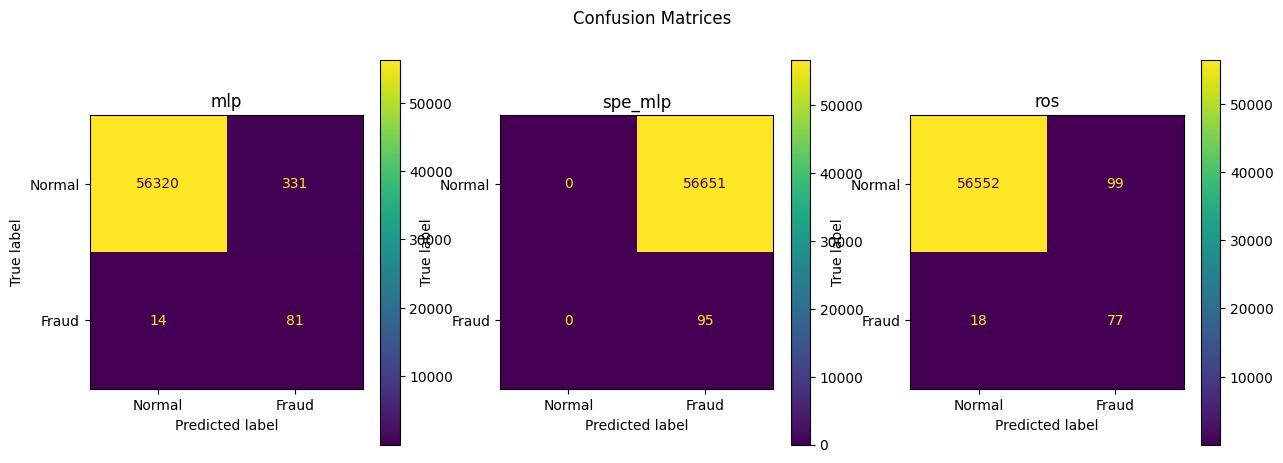

In [20]:
# evaluate each model on test set on f1, prec, recall and plot confusion matrix for each

# MLP Normal
y_test_pred = mlp_pipeline.predict(X_test)
print("\nMLP Normal")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE MLP
y_test_pred = mlp_spe_pipeline.predict(X_test)
print("\nSPE MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Random Oversampling MLP
y_test_pred = mlp_ros_pipeline.predict(X_test)
print("\nRandOver MLP")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([mlp_pipeline, mlp_spe_pipeline, mlp_ros_pipeline]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[1][0])
plt.show()
